#**Unsupervised pre-training**

*Students:* --Valentina Barletta (Deep Learning) valentina.barletta@edu.unito.it --Sara De Benedetti (Reti Neurali) sara.debenedetti493@edu.unito.it

# Encoder with Softmax


Importing Modules

In [1]:
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import torchvision
from statistics import mean
import numpy as np

from torchsummary import summary
from tqdm import tqdm

import os
import time

#path_data = 'MyDrive/Progetto Deep/Data/'
#model_path = '/content/drive/MyDrive/Progetto Deep/Data/model.pth'
#model_path = '/content/drive/MyDrive/Progetto Deep/Data/model_sparse.pth'


#from google.colab import drive
#drive.mount('/content/drive')

#subject = 'EncoderWithSoftmax'

Get the computation device

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)                                        # Check which device we got

cpu


## Our net: Pretrained Convolutional Encoder with Softmax

 Here it's represented the architecture of our Convolutional Autoencoder Neural Network pretrained.

In [3]:
input_dim = (28 * 28)
hidden_dim = 10
out_dim = 10

class Autoencoder(nn.Module):
    def __init__(self, input_dim, out_dim):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=1, padding=1),  # 28 x 28 x 1 -> 28 x 28 x 8
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # 28 x 28 x 8 -> 14 x 14 x 8
                                    nn.Conv2d(8, 4, kernel_size=3, padding=1),  # 14 x 14 x 8 -> 14 x 14 x 4
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2, padding=0)) # 14 x 14 x 4 -> 7 x 7 x 4


        # Decoder
        self.decoder = nn. Sequential(nn.Conv2d(4, 4, kernel_size=3, padding=1),  # 7 x 7 x 4 -> 7 x 7 x 4
                                      nn.ReLU(),
                                      nn.Upsample(scale_factor=2, mode='nearest'),  # 7 x 7 x 4 -> 14 x 14 x 4
                                      nn.Conv2d(4, 8, kernel_size=3, padding=1),  # 14 x 14 x 4 -> 14 x 14 x 8
                                      nn.ReLU(),
                                      nn.Upsample(scale_factor=2, mode='nearest'),  # 14 x 14 x 8 -> 28 x 28 x 8
                                      nn.Conv2d(8, 1, kernel_size=3, padding=1))  # 28 x 28 x 8 -> 28 x 28 x 1


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


pret_autoenc = Autoencoder(input_dim, out_dim).to(device)

Restoring the model

In [4]:
state_dict = torch.load("model_sparse.pth", map_location=torch.device('cpu'))
pret_autoenc.load_state_dict(state_dict)
# pretrained_autoencoder.eval()

<All keys matched successfully>

In this section, we will define our neural network made by our pretrained encoder combined with a softmax layer.

In [5]:
class EncoderWithSoftmax(nn.Module):
    def __init__(self, pretrained_autoencoder):
        super(EncoderWithSoftmax, self).__init__()

        # Extraction of the encoder from the pretrained autoencoder
        self.encoder = pretrained_autoencoder.encoder
        
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Add the sfotmax layer
        self.encoder_with_softmax = nn.Sequential(
            self.encoder,
            nn.Flatten(),
            nn.Linear(in_features = (4 * 7 * 7), out_features = 10),
            nn.Softmax(dim=1))


    def forward(self, x):

        x = self.encoder_with_softmax(x)
        return x

## Some Helper Functions

In [6]:
def accuracy(y_pred, y):

    pred = y_pred.detach().argmax(dim=1)
    corrects = (pred == y)
    accuracy = (corrects.sum()/corrects.size(0)).float()

    return accuracy


def evaluate(model, train_loader, test_loader):

  # initialize the accuracy as 0

    acc_train, acc_test = 0, 0
    running_loss = 0.0

    with torch.no_grad():

        for x_train, y_train in train_loader:

            x_train, y_train = x_train.to(device), y_train.to(device)        # remember that we need to load our data into the GPUs

            out = model(x_train).squeeze()
            acc_train += accuracy(out, y_train)

        for x_test, y_test in test_loader:

            x_test, y_test = x_test.to(device), y_test.to(device)

            out = model(x_test).squeeze()
            loss = loss_function(out, y_test)
            running_loss += loss.item()
            acc_test += accuracy(out, y_test)
            
        val_loss = running_loss / len(test_loader)
        acc_train, acc_test = acc_train / len(train_loader), acc_test / len(test_loader)

    return float(acc_train.detach()) * 100, float(acc_test.detach()) * 100, val_loss


def train(model, x, y, loss_function, optimizer):
    model.train()
    out = model(x).squeeze()
    
    loss = loss_function(out, y)

    optimizer.zero_grad()
    loss.backward()
    
    # Add Gradiet Clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

    optimizer.step()
    return float(loss)



**Loss Function and Optimizer**

For the loss function, we will use `CrossEntropyLoss` (Cross Entropy Loss).
The optimizer is going to be `Adam` with a learning rate of 0.001.

In [7]:
loss_function = nn.CrossEntropyLoss()

Prepare the Data

In [8]:
n_train = 8000
n_test = 350

batch_size_train = 16
batch_size_test = 32

transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])

## TEST SET

dataset_test =  torchvision.datasets.MNIST('./files/', train=False, download=True, transform=transform)

dataset_test.data, dataset_test.targets = dataset_test.data[n_train:(n_train + n_test)], dataset_test.targets[n_train:(n_train + n_test)]
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size = batch_size_test, shuffle = False)

Since we want to derive how the accuracy changes as the size of the training dataset decreases, here there is the code which trains a neural network on the MNIST dataset, adjusting the size of the training dataset for each iteration of the loop.



In [9]:
old_acc = []
old_train = []
old_test = []

ratio = 50
EPOCHS = 100
n_runs = 3

for j in range(n_runs):
    
    ACCURACY_matrix = []
    TrainLOSS_matrix = []
    TestLOSS_matrix = []
    
    print(f"Run Number: {j+1}")
    
    for i in range (1, ratio+1):

        train_losses = []
        test_losses = []
        test_accuracies = []

        # Set the datasetsize
        n_train_loop = int(n_train * i / ratio)
        #batch_size_train_loop = int(batch_size_train * i / ratio)

        # Create the train dataset and the train loader 
        dataset_train =  torchvision.datasets.MNIST('./files/', train = False, download = True, transform = transform)
        dataset_train.data, dataset_train.targets = dataset_train.data[:n_train_loop], dataset_train.targets[:n_train_loop]
        train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size_train, shuffle = True, drop_last = True)

        # Call our Net
        model = EncoderWithSoftmax(pret_autoenc).to(device)

        #Set the Optimazer
        optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

        for epoch in range(1,EPOCHS+1):
            train_loss = 0

            for x_train, y_train in train_loader:
                x_train, y_train = x_train.to(device), y_train.to(device)
                loss = train(model, x_train, y_train, loss_function, optimizer)
                train_loss += loss

            train_loss /= len(train_loader)                    # we divide by the number of batches
            train_losses.append(train_loss)

            train_acc, test_acc, test_loss = evaluate(model, train_loader, test_loader)
            test_accuracies.append(test_acc)
            test_losses.append(test_loss)

            if epoch % 25 == 0:
                print("Epoch:", epoch, "Loss:", float(train_loss), "Test Loss:", test_loss, "data:", len(dataset_train.data), "train_acc", train_acc, "test_acc", test_acc)

        # Save in ACCURACY_matrix
        ACCURACY_matrix.append(test_accuracies)
        TrainLOSS_matrix.append(train_losses)
        TestLOSS_matrix.append(test_losses)

    if j == 0:

        old_acc = ACCURACY_matrix
        old_train = TrainLOSS_matrix
        old_test = TestLOSS_matrix

    else:

        # For old_acc and ACCURACY_matrix
        old_acc = [[old_acc[row][col] + ACCURACY_matrix[row][col] for col in range(len(old_acc[0]))] for row in range(len(old_acc))]

        # For old_train and TrainLOSS_matrix
        old_train = [[old_train[row][col] + TrainLOSS_matrix[row][col] for col in range(len(old_train[0]))] for row in range(len(old_train))]

        # For old_test and TestLOSS_matrix
        old_test = [[old_test[row][col] + TestLOSS_matrix[row][col] for col in range(len(old_test[0]))] for row in range(len(old_test))]
        

    print("\n")

Run Number: 1
Epoch: 25 Loss: 1.8406848907470703 Test Loss: 1.9727541316639294 data: 160 train_acc 75.0 test_acc 57.1212112903595
Epoch: 50 Loss: 1.7128782153129578 Test Loss: 1.910385402766141 data: 160 train_acc 82.4999988079071 test_acc 63.12499642372131
Epoch: 75 Loss: 1.668516755104065 Test Loss: 1.8742278705943713 data: 160 train_acc 84.375 test_acc 64.82954621315002
Epoch: 100 Loss: 1.6478172540664673 Test Loss: 1.8556335080753674 data: 160 train_acc 85.6249988079071 test_acc 65.37878513336182
Epoch: 25 Loss: 1.7469920217990875 Test Loss: 1.847454916347157 data: 320 train_acc 80.9374988079071 test_acc 71.47727608680725
Epoch: 50 Loss: 1.6539054274559022 Test Loss: 1.7972961880943992 data: 320 train_acc 87.8125011920929 test_acc 71.7424213886261
Epoch: 75 Loss: 1.605153101682663 Test Loss: 1.7599196759137241 data: 320 train_acc 90.625 test_acc 75.17045736312866
Epoch: 100 Loss: 1.548667275905609 Test Loss: 1.7069080417806453 data: 320 train_acc 95.6250011920929 test_acc 80.284094

Epoch: 25 Loss: 1.5993228393442491 Test Loss: 1.6794787536967883 data: 2720 train_acc 89.00735378265381 test_acc 81.72348141670227
Epoch: 50 Loss: 1.5668653474134557 Test Loss: 1.60183631290089 data: 2720 train_acc 91.76470637321472 test_acc 88.25757503509521
Epoch: 75 Loss: 1.549630125129924 Test Loss: 1.5936838063326748 data: 2720 train_acc 93.5661792755127 test_acc 89.10984396934509
Epoch: 100 Loss: 1.541994894252104 Test Loss: 1.5842704989693381 data: 2720 train_acc 94.30146813392639 test_acc 88.80681991577148
Epoch: 25 Loss: 1.7212327573034498 Test Loss: 1.7192637053402988 data: 2880 train_acc 75.90277791023254 test_acc 75.70075988769531
Epoch: 50 Loss: 1.6409966515170202 Test Loss: 1.677101492881775 data: 2880 train_acc 84.44444537162781 test_acc 80.5681824684143
Epoch: 75 Loss: 1.6238395618067847 Test Loss: 1.6677743088115344 data: 2880 train_acc 85.17361283302307 test_acc 79.98105883598328
Epoch: 100 Loss: 1.6153316504425472 Test Loss: 1.669569969177246 data: 2880 train_acc 86.

Epoch: 100 Loss: 1.5366125673055648 Test Loss: 1.565019130706787 data: 5120 train_acc 94.08203363418579 test_acc 90.83333611488342
Epoch: 25 Loss: 1.5852295980308995 Test Loss: 1.6079253608530217 data: 5280 train_acc 90.56817889213562 test_acc 88.27651739120483
Epoch: 50 Loss: 1.5557849985180479 Test Loss: 1.5856841043992476 data: 5280 train_acc 92.08333492279053 test_acc 88.52272629737854
Epoch: 75 Loss: 1.5440816420497316 Test Loss: 1.5670144232836636 data: 5280 train_acc 92.84090995788574 test_acc 91.11742377281189
Epoch: 100 Loss: 1.5362073692408476 Test Loss: 1.5708962787281384 data: 5280 train_acc 93.40909123420715 test_acc 90.54924249649048
Epoch: 25 Loss: 1.5787454510436338 Test Loss: 1.5856828472831033 data: 5440 train_acc 90.18382430076599 test_acc 90.53030014038086
Epoch: 50 Loss: 1.5523973836618312 Test Loss: 1.5552752993323586 data: 5440 train_acc 92.24264621734619 test_acc 91.66666269302368
Epoch: 75 Loss: 1.5422867424347821 Test Loss: 1.559686693278226 data: 5440 train_a

Epoch: 75 Loss: 1.613798615336418 Test Loss: 1.6166567694057117 data: 7680 train_acc 85.69010496139526 test_acc 84.58333611488342
Epoch: 100 Loss: 1.6094617572923502 Test Loss: 1.6207176880402998 data: 7680 train_acc 86.22395992279053 test_acc 84.01515483856201
Epoch: 25 Loss: 1.576801005431584 Test Loss: 1.5504910187287764 data: 7840 train_acc 91.45408272743225 test_acc 92.25378632545471
Epoch: 50 Loss: 1.5438574340878701 Test Loss: 1.5478150844573975 data: 7840 train_acc 93.18877458572388 test_acc 91.98863506317139
Epoch: 75 Loss: 1.5340726857282678 Test Loss: 1.5410316857424649 data: 7840 train_acc 94.18367147445679 test_acc 92.84090399742126
Epoch: 100 Loss: 1.5275900531788262 Test Loss: 1.532462315125899 data: 7840 train_acc 94.69387531280518 test_acc 92.8219735622406
Epoch: 25 Loss: 1.5638447244167328 Test Loss: 1.551446795463562 data: 8000 train_acc 91.78749918937683 test_acc 93.12499761581421
Epoch: 50 Loss: 1.5422275674343109 Test Loss: 1.5326519012451172 data: 8000 train_acc 

Epoch: 75 Loss: 1.5598952795778003 Test Loss: 1.6048586151816628 data: 2240 train_acc 92.99107193946838 test_acc 87.38636374473572
Epoch: 100 Loss: 1.5463421838624136 Test Loss: 1.5830663334239612 data: 2240 train_acc 93.39285492897034 test_acc 89.39393758773804
Epoch: 25 Loss: 1.6616523742675782 Test Loss: 1.6625971035523848 data: 2400 train_acc 83.24999809265137 test_acc 84.2424213886261
Epoch: 50 Loss: 1.573967985312144 Test Loss: 1.615266507322138 data: 2400 train_acc 91.62499904632568 test_acc 87.40530014038086
Epoch: 75 Loss: 1.5540438604354858 Test Loss: 1.5956938700242476 data: 2400 train_acc 92.166668176651 test_acc 89.65909481048584
Epoch: 100 Loss: 1.543817215760549 Test Loss: 1.5978453917936846 data: 2400 train_acc 94.0833330154419 test_acc 87.12120652198792
Epoch: 25 Loss: 1.6015451334416866 Test Loss: 1.6414799798618664 data: 2560 train_acc 90.85937738418579 test_acc 85.70075631141663
Epoch: 50 Loss: 1.5676603727042675 Test Loss: 1.6178509322079746 data: 2560 train_acc 92

Epoch: 50 Loss: 1.5581636496384939 Test Loss: 1.581603548743508 data: 4800 train_acc 92.5208330154419 test_acc 88.80681991577148
Epoch: 75 Loss: 1.5463798137505849 Test Loss: 1.5759447704661975 data: 4800 train_acc 93.31250190734863 test_acc 90.24620652198792
Epoch: 100 Loss: 1.538298905690511 Test Loss: 1.5737100081010298 data: 4800 train_acc 93.50000023841858 test_acc 90.22727608680725
Epoch: 25 Loss: 1.6676364233416896 Test Loss: 1.6775465336712925 data: 4960 train_acc 81.57258033752441 test_acc 80.24621605873108
Epoch: 50 Loss: 1.5653540122893548 Test Loss: 1.595255819233981 data: 4960 train_acc 91.5725827217102 test_acc 87.95454502105713
Epoch: 75 Loss: 1.5488367588289322 Test Loss: 1.5856066942214966 data: 4960 train_acc 93.34677457809448 test_acc 88.80681991577148
Epoch: 100 Loss: 1.5391364389850248 Test Loss: 1.577186573635448 data: 4960 train_acc 93.60886812210083 test_acc 89.98106122016907
Epoch: 25 Loss: 1.6745512917637826 Test Loss: 1.7188520539890637 data: 5120 train_acc 8

Epoch: 25 Loss: 1.5628434590671374 Test Loss: 1.5576463504271074 data: 7360 train_acc 91.9021725654602 test_acc 92.27272272109985
Epoch: 50 Loss: 1.544587623813878 Test Loss: 1.5494764176282017 data: 7360 train_acc 93.5190200805664 test_acc 92.84090399742126
Epoch: 75 Loss: 1.5344864371030227 Test Loss: 1.5323834744366733 data: 7360 train_acc 94.18478012084961 test_acc 93.99621486663818
Epoch: 100 Loss: 1.5281826164411463 Test Loss: 1.5372219194065442 data: 7360 train_acc 94.68749761581421 test_acc 92.8219735622406
Epoch: 25 Loss: 1.562840839142495 Test Loss: 1.5482170581817627 data: 7520 train_acc 91.59574508666992 test_acc 93.14393997192383
Epoch: 50 Loss: 1.5441997822294844 Test Loss: 1.5396110686388882 data: 7520 train_acc 93.45744848251343 test_acc 93.12499761581421
Epoch: 75 Loss: 1.5345831728996115 Test Loss: 1.538241364739158 data: 7520 train_acc 94.1356360912323 test_acc 93.40908527374268
Epoch: 100 Loss: 1.5280246671209945 Test Loss: 1.532295053655451 data: 7520 train_acc 94.

Epoch: 25 Loss: 1.6105259547630946 Test Loss: 1.6675286293029785 data: 1920 train_acc 90.1562511920929 test_acc 81.98863863945007
Epoch: 50 Loss: 1.5723613311847051 Test Loss: 1.6305826360529119 data: 1920 train_acc 92.60416626930237 test_acc 85.11363863945007
Epoch: 75 Loss: 1.553572095433871 Test Loss: 1.623516776344993 data: 1920 train_acc 93.4374988079071 test_acc 85.96591353416443
Epoch: 100 Loss: 1.543388259410858 Test Loss: 1.626379977573048 data: 1920 train_acc 94.11458373069763 test_acc 85.11363863945007
Epoch: 25 Loss: 1.6726605883011452 Test Loss: 1.7061133818192915 data: 2080 train_acc 81.63461685180664 test_acc 78.27651500701904
Epoch: 50 Loss: 1.638184363108415 Test Loss: 1.6926462867043235 data: 2080 train_acc 84.375 test_acc 78.56060266494751
Epoch: 75 Loss: 1.622032476388491 Test Loss: 1.6936801888725974 data: 2080 train_acc 85.67307591438293 test_acc 77.68939733505249
Epoch: 100 Loss: 1.6149106172414927 Test Loss: 1.690192168409174 data: 2080 train_acc 86.730766296386

Epoch: 25 Loss: 1.6553975701332093 Test Loss: 1.682466138492931 data: 4480 train_acc 82.63393044471741 test_acc 79.69696521759033
Epoch: 50 Loss: 1.6334217416388648 Test Loss: 1.6569972146641125 data: 4480 train_acc 84.46428775787354 test_acc 80.83333373069763
Epoch: 75 Loss: 1.6229748210736683 Test Loss: 1.6440210234035144 data: 4480 train_acc 84.82142686843872 test_acc 83.6931824684143
Epoch: 100 Loss: 1.6165113419294357 Test Loss: 1.6488747054880315 data: 4480 train_acc 85.44642925262451 test_acc 81.70454502105713
Epoch: 25 Loss: 1.6452770512679527 Test Loss: 1.651317531412298 data: 4640 train_acc 83.29741358757019 test_acc 82.51894116401672
Epoch: 50 Loss: 1.5625542447484773 Test Loss: 1.583331043070013 data: 4640 train_acc 92.60776042938232 test_acc 89.10984396934509
Epoch: 75 Loss: 1.5486135273144164 Test Loss: 1.5735180486332287 data: 4640 train_acc 93.40517520904541 test_acc 90.53030014038086
Epoch: 100 Loss: 1.539247533781775 Test Loss: 1.564588340845975 data: 4640 train_acc 9

Epoch: 100 Loss: 1.5319399589716003 Test Loss: 1.5455685962330212 data: 6880 train_acc 94.11337375640869 test_acc 91.95075631141663
Epoch: 25 Loss: 1.657977064631202 Test Loss: 1.6685696190053767 data: 7040 train_acc 82.01704621315002 test_acc 80.79545497894287
Epoch: 50 Loss: 1.5497314084659923 Test Loss: 1.5444317839362405 data: 7040 train_acc 92.99715757369995 test_acc 92.8219735622406
Epoch: 75 Loss: 1.5378237916664643 Test Loss: 1.5397690642963757 data: 7040 train_acc 93.92045736312866 test_acc 92.8219735622406
Epoch: 100 Loss: 1.5316101347858255 Test Loss: 1.5454384630376643 data: 7040 train_acc 94.24715638160706 test_acc 91.66666269302368
Epoch: 25 Loss: 1.6357168001598783 Test Loss: 1.639449488032948 data: 7200 train_acc 83.33333134651184 test_acc 83.73106122016907
Epoch: 50 Loss: 1.6210574520958794 Test Loss: 1.6256079565395007 data: 7200 train_acc 84.97222065925598 test_acc 83.4280252456665
Epoch: 75 Loss: 1.6130900825394525 Test Loss: 1.627656557343223 data: 7200 train_acc 8

Implement the average

In [10]:
ACCURACY_matrix = [[element / n_runs for element in row] for row in old_acc]
TrainLOSS_matrix = [[element / n_runs for element in row] for row in old_train]
TestLOSS_matrix = [[element / n_runs for element in row] for row in old_test]

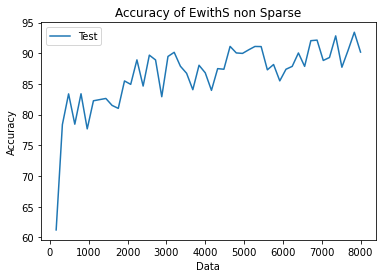

In [11]:
last_elements = [sublist[-1] for sublist in ACCURACY_matrix]

# The size of the dataset
data = [n_train * i/ratio for i in range(1, ratio + 1)]

# Plot the values
plt.plot(data, last_elements, label = "Test")
plt.xlabel("Data")
plt.ylabel("Accuracy")
plt.title('Accuracy of EwithS non Sparse')
plt.legend()
plt.show()

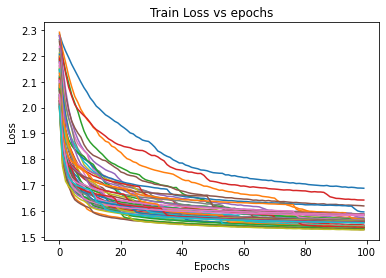

In [12]:
for i in range(len(TrainLOSS_matrix)):
    plt.plot(range(EPOCHS), TrainLOSS_matrix[i])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Train Loss vs epochs')
plt.show()

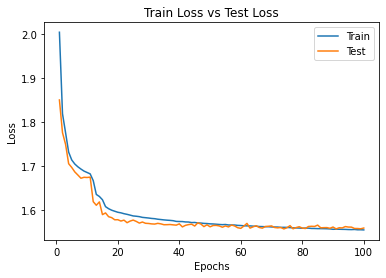

In [13]:
plt.plot(range(1, EPOCHS + 1), TrainLOSS_matrix[-1], label = "Train")
plt.plot(range(1, EPOCHS + 1), TestLOSS_matrix[-1], label = "Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Train Loss vs Test Loss')
plt.legend()
plt.show()

*Salvataggio dei dati*

In [14]:
result_dir = 'result'
os.makedirs(result_dir, exist_ok=True)

file_name1 = 'TrainLOSS_matrix_model_sparse.npy'
np.save(os.path.join(result_dir, file_name1), TrainLOSS_matrix)

file_name2 = 'ACCURACY_matrix_model_sparse.npy'
np.save(os.path.join(result_dir, file_name2), ACCURACY_matrix)

file_name3 = 'TestLOSS_matrix_model_sparse.npy'
np.save(os.path.join(result_dir, file_name3), TestLOSS_matrix)

**Confusion Matrix**

In [15]:
from sklearn.metrics import confusion_matrix
import numpy as np
model.eval()

all_y = []
all_predictions = []

# Iterate over the dataset
for x, y in test_loader:
    x = x.to(device)

    with torch.no_grad():
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)

    all_y.extend(y.numpy())
    all_predictions.extend(predicted.cpu().numpy())

all_y = np.array(all_y)
all_predictions = np.array(all_predictions)

conf_matrix = confusion_matrix(all_y, all_predictions, normalize = "true")

print(conf_matrix.round(decimals=2))

[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.97 0.   0.   0.   0.   0.   0.   0.03 0.  ]
 [0.03 0.   0.78 0.   0.11 0.   0.   0.   0.06 0.03]
 [0.   0.   0.   0.89 0.   0.   0.   0.   0.11 0.  ]
 [0.   0.   0.   0.   0.95 0.   0.05 0.   0.   0.  ]
 [0.   0.   0.   0.04 0.   0.93 0.   0.   0.04 0.  ]
 [0.   0.   0.   0.   0.   0.03 0.97 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.03 0.03 0.   0.   0.94 0.  ]
 [0.03 0.   0.   0.   0.03 0.   0.   0.   0.   0.94]]


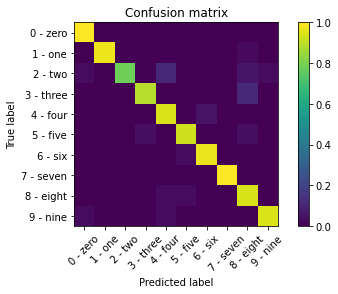

In [16]:
classes =dataset_test.classes

plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix)
plt.title("Confusion matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)


plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()